# Description

This notebook shows of to use CLimLoco1.0, using a simple example on the global mean surface air temperature (GSAT).

## Packages importations

In [1]:
# Import packages
import sys
import numpy as np
from xarray import open_dataset
import matplotlib.pyplot as plt

# Import our functions
sys.path.append("..")
from functions.format_data import *
from functions.display_figures_case_study import *
from functions.compute_confidence_intervals import *

# Parameters (user choices)

In [2]:
# Choice of the reference period, X and Y
# Here, Y is the 2081-2100 mean GSAT, relative to 1850-1900
#   and X is the 2015-2024 mean GSAT, relative to 1850-1900
reference_period = [1850, 1900]
period_Y         = [2081, 2100]
period_X         = [2015, 2024]

# Confidence level for the confidence intervals
confidence_level = 0.90 # 90 %

# Import data from climate models

Here, we import the data from CMIP6 that we already preprocessed:
- "CMIP6_name_models" contains the name of the climate models
- "CMIP6_times" contains the label of each year
- "CMIP6_global_tas" contains the GSAT timeseries (annual) for each climate model

In [3]:
# Import the data for each model, each year and each spatial position
CMIP6_name_models = np.load("../data/ssp245_timeserie_global_tas/name_models.npy")
CMIP6_times       = np.load("../data/ssp245_timeserie_global_tas/times.npy").astype(str).astype(int)
CMIP6_global_tas  = np.load("../data/ssp245_timeserie_global_tas/data.npy")- 273.15

print("We got {} climate models simulating times between {} and {}.".format(len(CMIP6_name_models), np.min(CMIP6_times), np.max(CMIP6_times)))

# Transform the timeseries into anomalies
X_ref = compute_X_from_period(reference_period, CMIP6_times, CMIP6_global_tas)
CMIP6_global_tas -= X_ref.reshape(-1,1)

We got 32 climate models simulating times between 1850 and 2100.


# Import data from real-world observation
HadCRUT5 analysis time series. The data originates from *https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/download.html*

This is a reanalysis, enabling thus to have multiple realisations, useful later.

In [4]:
# Extract data from the file
data_HadCrut5 = open_dataset("../data/HadCRUT.5.0.2.0.analysis.ensemble_series.global.annual.nc")
time_HadCrut5 = data_HadCrut5.time.data.astype("datetime64[Y]").astype(str).astype(int)
global_tas_obs_perRealisation_perTime = data_HadCrut5["tas"].data

print("There is {} realisations, between {} and {}".format(global_tas_obs_perRealisation_perTime.shape[0], time_HadCrut5.min(), time_HadCrut5.max()))

# Transform the timeseries into anomalies
X_ref_obs = compute_X_from_period(reference_period, time_HadCrut5, global_tas_obs_perRealisation_perTime)
global_tas_obs_perRealisation_perTime -= X_ref_obs.reshape(-1,1)

There is 200 realisations, between 1850 and 2025


# Compute Y, X and X_obs
Notations:
- M the number of climate models
- p the number of variables in X (here, p=1)
- n the number of realisations of the observed dataset

Dimensions:
- Y is a vector of size M
- X is a matrix of size (M,p)
- X_obs is a matrix of size (n,p)

There is two cases:
- You have multiple realisations (n>1), enabling to compute the covariance-matrix of the observational noise Cov_N. Cov_N is directly computed in the following function "compute_confidence_intervals_X_multivariate".
- You have only one observation (n=1). In this case, you have to indicate manually Cov_N, by entering precomputed_Cov_N=Cov_N in the input of the function following function "compute_confidence_intervals_X_multivariate".

This notebook shows an univariate (p=1) example, but is totally functional if X is multivariate (p>1). Feel free to modify X (and Y). For a multivariate example, see the notebook "case_study" in the same repository.

In [9]:
Y     = compute_X_from_period(period_Y, CMIP6_times, CMIP6_global_tas)
X     = compute_X_from_period(period_X, CMIP6_times, CMIP6_global_tas).reshape(-1,1)
X_obs = compute_X_from_period(period_X, time_HadCrut5, global_tas_obs_perRealisation_perTime).reshape(-1,1)

print("Dimensions of Y, X and X_obs:", Y.shape, X.shape, X_obs.shape)

Dimensions of Y, X and X_obs: (32,) (32, 1) (200, 1)


# Compute the confidence intervals

In [6]:
[constrained_CI, unconstrained_CI, array_x, constrained_CI_per_x
] = compute_confidence_intervals_X_multivariate(X, X_obs, Y, confidence_level, period_Y, reference_period, return_for_different_x=True)

90% confidence:
Global temperature at surface in 2081-2100 relative to 1850-1900:
Constrained : [3.01 +- 0.74]
Unconstrained : [3.05 +- 1.17]


# Illustration of the observational constraint

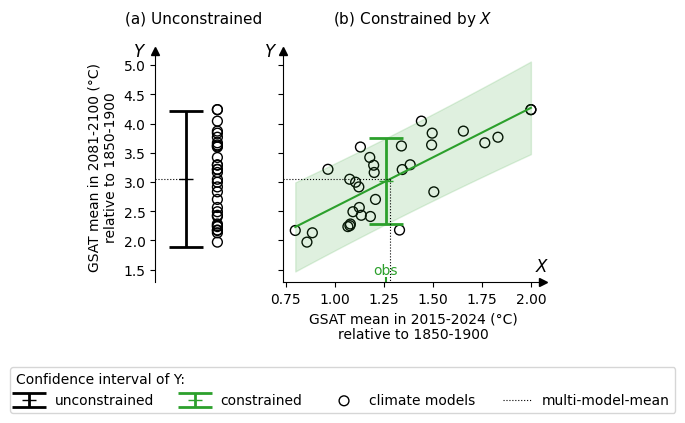

In [7]:
display_CI_Y_YX(Y, X, X_obs, unconstrained_CI,
                        constrained_CI, array_x, constrained_CI_per_x,
                        period_Y, period_X, reference_period)

# Quantification of the uncertainty reduction

In [20]:
uncertainty_reduction = np.diff(constrained_CI)[0]/np.diff(unconstrained_CI)[0]

print("The uncertainty is reduced by {}%.".format(int(100*(1-uncertainty_reduction))))

The uncertainty is reduced by 36%.
